# Sample Tweet Analysis

This notebook aims to classify the various given in the dataset as sarcastic or not. The tweets are not in English, hence it would be difficult to find pretrained embeddings for them. The dataset consists of 500 samples, with each sample only two columns:
- `sarcasm`: A boolean indicating whether the tweet was sarcastic or not
- `processed_tweet`: Content of the tweet after some processing, like removal of hashtags, tags and emojis.

In [11]:
import pandas as pd

# Load the dataset
df = pd.read_csv("data/sample_tweets.csv", sep=',', names=['label', 'text'], header=0)

df.head()

,label,text
0,1,ka bhagwan bar ka ram lakh lakh pe shukra hai ...
1,0,Triple talaq illegal ho gaya hai .
2,0,Tum Ka Triple Talaq Halala ke Alawa kuch nahi ...
3,1,bol the dialogue :'tu aik ek insaan pakistan k...
4,0,bhai aap ki karachi say kia dushmani hay ? saa...


In [12]:
from sklearn.model_selection import train_test_split

tweets = df["text"].values
y = df["label"].values

# Divide into a 25% test set and 75% training set
tweets_train, tweets_test, y_train, y_test = train_test_split(
  tweets, y, test_size=0.25, random_state=1000
)

print("Training set length: ", len(tweets_train))
print("Test set length: ", len(tweets_test))

Training set length:  375
Test set length:  125


In [13]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

# Create a charitng utility to plot the graphs for accuracy and loss
def plot_history(history):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, "b", label="Training acc")
  plt.plot(x, val_acc, "r", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, "b", label="Training loss")
  plt.plot(x, val_loss, "r", label="Validation loss")
  plt.title("Training and validation loss")
  plt.legend()

## Model 1: Count Vectorization + Neural Network

We will use a simple `Bag of Words` encoding to convert the sentences to a vocabulary, and then embed each sentence where each index represents the frequency of the word in that sentence for the word at that index in the vocabulary. BOW is used to represent the sequence of words (sentence) as single feature vector. We will use a linear-regression model to classify the same.

- `CountVectorizer` performs tokenization which separates the sentences into a set of tokens as you saw previously in the vocabulary. It additionally removes punctuation and special characters.
- We made use of a simple Neural Network with one dense layer of `10` neurons, and one output neuron.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras import layers

# Use CountVectorizer to convert the text tweets to vectors of word counts
vectorizer = CountVectorizer()
vectorizer.fit(tweets_train)

X_train = vectorizer.transform(tweets_train)
X_test = vectorizer.transform(tweets_test)

input_dim = X_train.shape[1]  # Size of the vocabulary

# Build a simple Neural Network with only two layers
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                26330     
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 26341 (102.89 KB)
Trainable params: 26341 (102.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

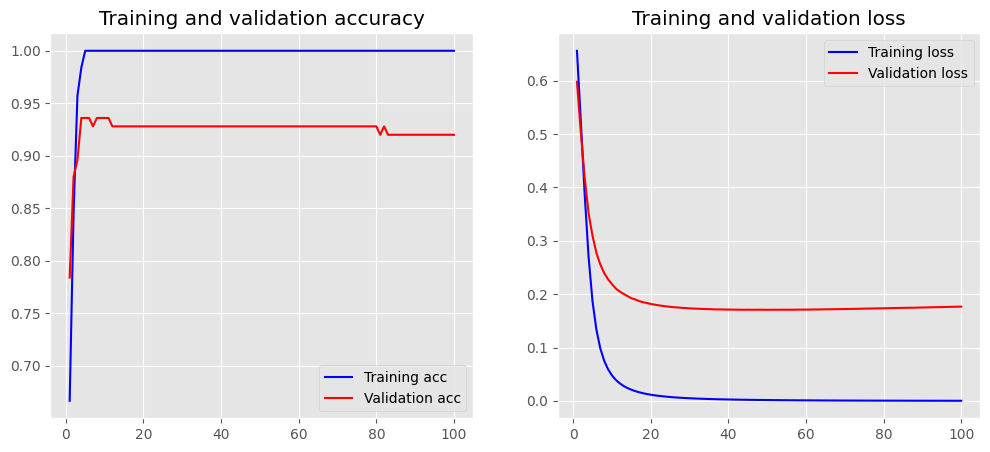

In [15]:
# Train the model and plot the accuracy and loss graphs
from keras.backend import clear_session

# Clear any previous data from the session
clear_session()

history = model.fit(
  X_train,
  y_train,
  epochs=100,
  verbose="False",
  validation_data=(X_test, y_test),
  batch_size=10,
)

loss, accuracy = model.evaluate(X_train, y_train, verbose="False")
print("Training Accuracy: {:.4f}%".format(accuracy*100))
loss, accuracy = model.evaluate(X_test, y_test, verbose="False")
print("Testing Accuracy:  {:.4f}%".format(accuracy*100))

plot_history(history)

### Model 2: Neural Network with Simple Index-based Embedding

For embedding in this case, we use `Kera's Tokenizer`, which first calculates the vocabulary as the distinct words in all the training sentences, and then assigns each one of them an index used to identify them. Then each sentence is converted to an array of indexes to represent it. To ensure the dimensions of each sentence are the same, we manually define the `maxlen` parameter and then pad the arrays accordingly.

- Since we do not have any pretrained embeddings for these words, we create random embeddings into 50 dimensions for each of the words and allow the model to train them during the learning process.
- We use the same architecture as the previous model, but with an additional `Embedding` and `Flatten` layer.
- We do not use any pooling layers as we don't have a long context available to us.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           133650    
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 10)                50010     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 183671 (717.46 KB)
Trainable params: 183671 (717.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
E

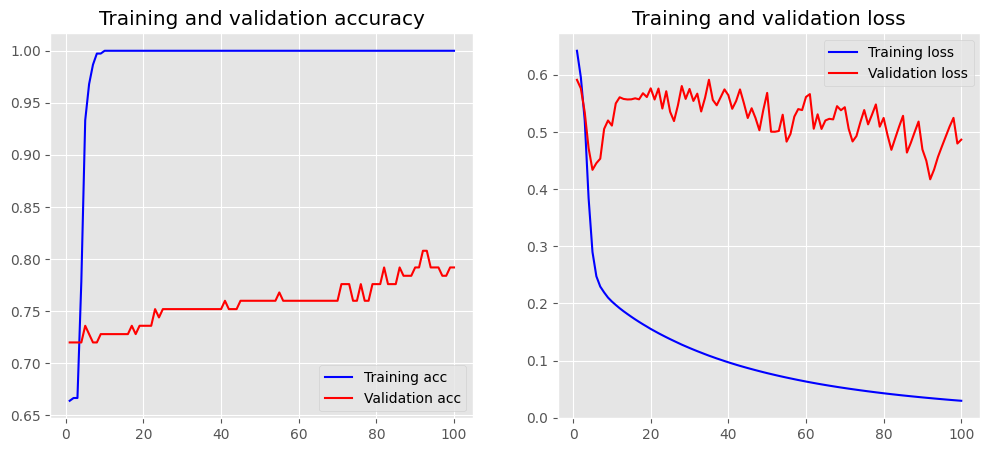

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers

tokenizer = Tokenizer(num_words=2500)
tokenizer.fit_on_texts(tweets_train)

X_train = tokenizer.texts_to_sequences(tweets_train)
X_test = tokenizer.texts_to_sequences(tweets_test)

vocab_size = (
  len(tokenizer.word_index) + 1
)  # Adding 1 because of reserved 0 index for padding


maxlen = 100
X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

embedding_dim = 50

model = Sequential()
# input_dim is the size of the vocabulary
# input_length is the length of the input sequences (maxlen)
model.add(
  layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=maxlen,
    trainable=True
  )
)
# We need to add a Flatten layer to flatten the 2D matrix into a 1D vector
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(
  X_train,
  y_train,
  epochs=100,
  verbose="False",
  validation_data=(X_test, y_test),
  batch_size=10,
)

loss, accuracy = model.evaluate(X_train, y_train, verbose="False")
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose="False")
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

It can be seen that this model doesn not perform better than the previous model. The primary reason of the same can be the limited size of the dataset that is provided to us. In the absence of pretrained embeddings, the model doesn't have enough contextual information to meaning generate the new embeddings and process them.

## Model 3: Transformers and BERT

We make use of the following pretrained BERT components in this model:
- **BERT Preprocessor:** It prepares input data in the required format for BERT by tokenizing and performing necessary preprocessing steps.
- **BERT Encoder:** It utilizes a pre-trained BERT model to generate contextualized word embeddings, producing a fixed-size representation of the input sequence.

In the model, we make use of the following layers:
- **Text Input Layer:** Takes tweet text as input.
- **BERT Preprocessing Layer:** Applies BERT preprocessing to the input text.
- **BERT Encoder Output:** Obtains contextualized word embeddings from the BERT encoder.
- **Neural Network Layers:**
  - **Dropout Layer (`l`):** Introduces dropout regularization to prevent overfitting.
  - **Dense Layer (`output`):** Produces the final output with a sigmoid activation function for binary classification.


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
import keras

%pip install tensorflow-text
import tensorflow_text as text

# Download the BERT preprocessor and encoder from the web
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [18]:
# Create a traing and validation set
tweets = df["text"].values
y = df["label"].values

# Divide into a 25% test set and 75% training set
tweets_train, tweets_test, y_train, y_test = train_test_split(
  tweets, y, test_size=0.25, random_state=1000
)

In [19]:
# Bert layers
text_input = keras.layers.Input(name='text', shape=(), dtype=tf.string)
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural Network layers
l = keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Construct the final model
model = keras.Model(inputs=[text_input], outputs = [l])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
  tweets_train,
  y_train,
  epochs=50,
  batch_size = 32
)

Epoch 1/50
12/12 [==============================] - 11s 330ms/step - loss: 0.7165 - accuracy: 0.6000
Epoch 2/50
12/12 [==============================] - 4s 296ms/step - loss: 0.6956 - accuracy: 0.5947
Epoch 3/50
12/12 [==============================] - 4s 298ms/step - loss: 0.6515 - accuracy: 0.6667
Epoch 4/50
12/12 [==============================] - 4s 317ms/step - loss: 0.6469 - accuracy: 0.6693
Epoch 5/50
12/12 [==============================] - 4s 307ms/step - loss: 0.6351 - accuracy: 0.6747
Epoch 6/50
12/12 [==============================] - 4s 299ms/step - loss: 0.6317 - accuracy: 0.6560
Epoch 7/50
12/12 [==============================] - 4s 301ms/step - loss: 0.6443 - accuracy: 0.6587
Epoch 8/50
12/12 [==============================] - 4s 331ms/step - loss: 0.6387 - accuracy: 0.6800
Epoch 9/50
12/12 [==============================] - 4s 300ms/step - loss: 0.6152 - accuracy: 0.6827
Epoch 10/50
12/12 [==============================] - 4s 301ms/step - loss: 0.6278 - accuracy: 0.666

In [20]:
test_loss, test_acc = model.evaluate(
  tweets_test,
  y_test,
  batch_size=32
)

print("Accuracy: ", test_acc)
print("Loss: ", test_loss)

4/4 [==============================] - 2s 306ms/step - loss: 0.5256 - accuracy: 0.7440
Accuracy:  0.7440000176429749
Loss:  0.5255933403968811
